# HTE I: Binary treatment

## Experiment Description
As a running example, in what follows we'll be using an abridged version of a public dataset from the General Social Survey (GSS) [(Smith, 2016)](https://gss.norc.org/Documents/reports/project-reports/GSSProject%20report32.pdf). The setting is a randomized control trial. Individuals were asked about their thoughts on government spending on the social safety net. The treatment is the wording of the question: about half of the individuals were asked if they thought government spends too much on "welfare" $(W_i = 1)$, while the remaining half was asked about "assistance to the poor" $(W_i = 0)$. The outcome is binary, with $Y_i = 1$ corresponding to a positive answer. In the data set below, we also collect a few other demographic covariates.

## Analysis

Source RMD file: [link](https://docs.google.com/uc?export=download&id=1FSUi4WLfYYKnvWsNWypiQORhkqf5IlFP)

In the previous chapter, we learned how to estimate the effect of a binary treatment averaged over the entire population. However, the average may obscure important details about how different individuals react to the treatment. In this chapter, we will learn how to estimate the **conditional average treatment effect (CATE)**,
\begin{equation}
  \tau(x) := E[Y_i(1) - Y_i(0) | X_i = x],
\end{equation}
which is a "localized" version of the average treatment effect conditional on a vector of observable characteristics. 

It's often the case that \@ref(eq:cate) is too general to be immediately useful, especially when the observable covariates are high-dimensional. It can be hard to estimate reliably without making strong modeling assumptions, and hard to summarize in a useful manner after estimation. In such situations, we will instead try to estimate treatment effect averages for simpler groups
\begin{equation}
  E[Y_i(1) - Y_i(0) | G_i = g],
\end{equation}
where $G_i$ indexes subgroups of interest. Below you'll learn how to estimate and test hypotheses about pre-defined subgroups, and also how to discover subgroups of interest from the data. In this tutorial, you will learn how to use estimates of \@ref(eq:cate) to suggest relevant subgroups $G_i$ (and in the next chapters you will find out other uses of \@ref(eq:cate) in policy learning and evaluation).

We'll continue using the abridged version of the General Social Survey (GSS) [(Smith, 2016)](https://gss.norc.org/Documents/reports/project-reports/GSSProject%20report32.pdf) dataset that was introduced in the previous chapter. In this dataset, individuals were sent to treatment or control with equal probability, so we are in a randomized setting. However, many of the techniques and code shown below should also work in an observational setting provided that unconfoundedness and overlap are satisfied (these assumptions were defined in the previous chapter).

In [1]:
# The causalTree package is not in CRAN, the most common R repository.
# To install it, uncomment the next lines as appropriate.
# install.packages("devtools")  # if you don't have this installed yet.
# devtools::install_github('susanathey/causalTree') 
library(causalTree)

# use e.g., install.packages("grf") to install any of the following packages.
library(grf)
library(rpart)
library(glmnet)
library(splines)
library(MASS)
library(lmtest)
library(sandwich)
library(ggplot2)

Loading required package: rpart

Loading required package: rpart.plot

Warning message:
"package 'rpart.plot' was built under R version 4.0.5"
Loading required package: data.table

Warning message:
"package 'data.table' was built under R version 4.0.5"
Warning message:
"package 'grf' was built under R version 4.0.5"
Loading required package: Matrix

Loaded glmnet 4.1-3

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




As with other chapters in this tutorial, the code below should still work by replacing the next snippet of code with a different dataset, provided that you update the key variables `treatment`, `outcome`, and `covariates` below. Also, please make sure to read the comments as they may be subtle differences depending on whether your dataset was created in a randomized or observational setting.

In [2]:
# Read in data
data <- read.csv("https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download")
n <- nrow(data)

# Treatment: does the the gov't spend too much on "welfare" (1) or "assistance to the poor" (0)
treatment <- "w"

# Outcome: 1 for 'yes', 0 for 'no'
outcome <- "y"

# Additional covariates
covariates <- c("age", "polviews", "income", "educ", "marital", "sex")

## Pre-specified hypotheses

We will begin by learning how to test pre-specified null hypotheses of the form
\begin{equation} 
\label{eq:1}
H_{0}: E[Y(1) - Y(0) | G_i = 1] = E[Y(1) - Y(0) | G_i = 0] 
\end{equation}

That is, that the treatment effect is the same regardless of membership to some group
$G_i$. Importantly, for now we’ll assume that the group $G_i$ was **pre-specified** -- it was decided _before_ looking at the data.

In a randomized setting, if the both the treatment  $W_i$ and group membership $G_i$ are binary, we can write
\begin{equation}
  E[Y_i(W_i)|G_i] = E[Y_i|W_i, G_i] = \beta_0 + \beta_w W_i + \beta_g G_i + \beta_{wg} W_i G_i
\end{equation}

<font size=1>
When $W_i$ and $G_i$ are binary, this decomposition is true without loss of generality. Why?
</font>

This allows us to write the average effects of $W_i$ and $G_i$ on $Y_i$ as
\begin{equation}
  \begin{aligned}
    E[Y(1) | G_i=1] &= \beta_0 + \beta_w W_i + \beta_g G_i + \beta_{wg} W_i G_i, \\
    E[Y(1) | G_i=0] &= \beta_0 + \beta_w W_i,  \\
    E[Y(0) | G_i=1] &= \beta_0 + \beta_g G_i,  \\
    E[Y(0) | G_i=0] &= \beta_0.
  \end{aligned}
\end{equation}

Rewriting the null hypothesis \ref{eq:1} in terms of the decomposition \@ref(eq:decomp), we see that it boils down to a test about the coefficient in the interaction: $\beta_{xw} = 0$. Here’s an example that tests whether the treatment effect is the same for "conservative" (`polviews` < 4) and "liberal" (`polviews` $\geq$ 4) individuals.

In [3]:
# Only valid in randomized settings

# Suppose this his group was defined prior to collecting the data
data$conservative <- factor(data$polviews < 4)  # a binary group
group <- 'conservative'

# Recall from last chapter -- this is equivalent to running a t-test
fmla <- formula(paste(outcome, ' ~ ', treatment, '*', group))
ols <- lm(fmla, data=data)
coeftest(ols, vcov=vcovHC(ols, type='HC2'))


t test of coefficients:

                     Estimate Std. Error t value  Pr(>|t|)    
(Intercept)         0.4836473  0.0050842  95.127 < 2.2e-16 ***
w                  -0.3789182  0.0058604 -64.657 < 2.2e-16 ***
conservativeTRUE   -0.1590214  0.0092479 -17.195 < 2.2e-16 ***
w:conservativeTRUE  0.1160034  0.0103710  11.185 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


## Data-driven hypotheses

Pre-specifying hypotheses prior to looking at the data is in general good practice to avoid "p-hacking" (e.g., slicing the data into different subgroups until a significant result is found). However, valid tests can also be attained if by **sample splitting**: we can use a subset of the sample to find promising subgroups, then test hypotheses about these subgroups in the remaining sample. This kind of sample splitting for hypothesis testing is called **honesty**.

### Via causal trees

**Causal trees** [(Athey and Imbens)](PNAS, 2016)](https://www.pnas.org/content/pnas/113/27/7353.full.pdf) are an intuitive algorithm that is available in the randomized setting to discover subgroups with different treatment effects.

At a high level, the idea is to divide the sample into three subsets (not necessarily of equal size). The `splitting` subset is used to fit a decision tree whose objective is modified to maximize heterogeneity in treatment effect estimates across leaves. The `estimation` subset is then used to produce a valid estimate of the treatment effect at each leaf of the fitted tree. Finally, a `test` subset can be used to validate the tree estimates.

The next snippet uses `honest.causalTree` function from the [`causalTree`](https://github.com/susanathey/causalTree) package. For more details, see the [causalTree documentation](https://github.com/susanathey/causalTree/blob/master/briefintro.pdf).

In [4]:
# Only valid for randomized data!
fmla <- paste(outcome, " ~", paste(covariates, collapse = " + "))
fmla

[1] "y  ~ age + polviews + income + educ + marital + sex"

In [5]:
# Dividing data into three subsets
indices <- split(seq(nrow(data)), sort(seq(nrow(data)) %% 3))
names(indices) <- c('split', 'est', 'test')

In [6]:
# Fitting the forest
ct.unpruned <- honest.causalTree(
  formula=fmla,            # Define the model
  data=data[indices$split,],
  treatment=data[indices$split, treatment],
  est_data=data[indices$est,],
  est_treatment=data[indices$est, treatment],
  minsize=1,                 # Min. number of treatment and control cases in each leaf
  HonestSampleSize=length(indices$est), #  Num obs used in estimation after splitting
  
  # We recommend not changing the parameters below
  split.Rule="CT",            # Define the splitting option
  cv.option="TOT",            # Cross validation options
  cp=0,                       # Complexity parameter
  split.Honest=TRUE,          # Use honesty when splitting
  cv.Honest=TRUE              # Use honesty when performing cross-validation
)

[1] 2
[1] "CT"


In [7]:
# Table of cross-validated values by tuning parameter.
ct.cptable <- as.data.frame(ct.unpruned$cptable)

In [8]:
# Obtain optimal complexity parameter to prune tree.
cp.selected <- which.min(ct.cptable$xerror)

In [9]:
cp.optimal <- ct.cptable[cp.selected, "CP"]

# Prune the tree at optimal complexity parameter.
ct.pruned <- prune(tree=ct.unpruned, cp=cp.optimal)

In [10]:
# Predict point estimates (on estimation sample)
tau.hat.est <- predict(ct.pruned, newdata=data[indices$est,])

# Create a factor column 'leaf' indicating leaf assignment in the estimation set
num.leaves <- length(unique(tau.hat.est))
leaf <- factor(tau.hat.est, levels=sort(unique(tau.hat.est)), labels = seq(num.leaves))

Note: if your tree is not splitting at all, try decreasing the parameter `minsize` that controls the minimum size of each leaf. The next snippet plots the learned tree. The values in the cell are the estimated treatment effect and an estimate of the fraction of the population that falls within each leaf. Both are estimated using the `estimation` sample.

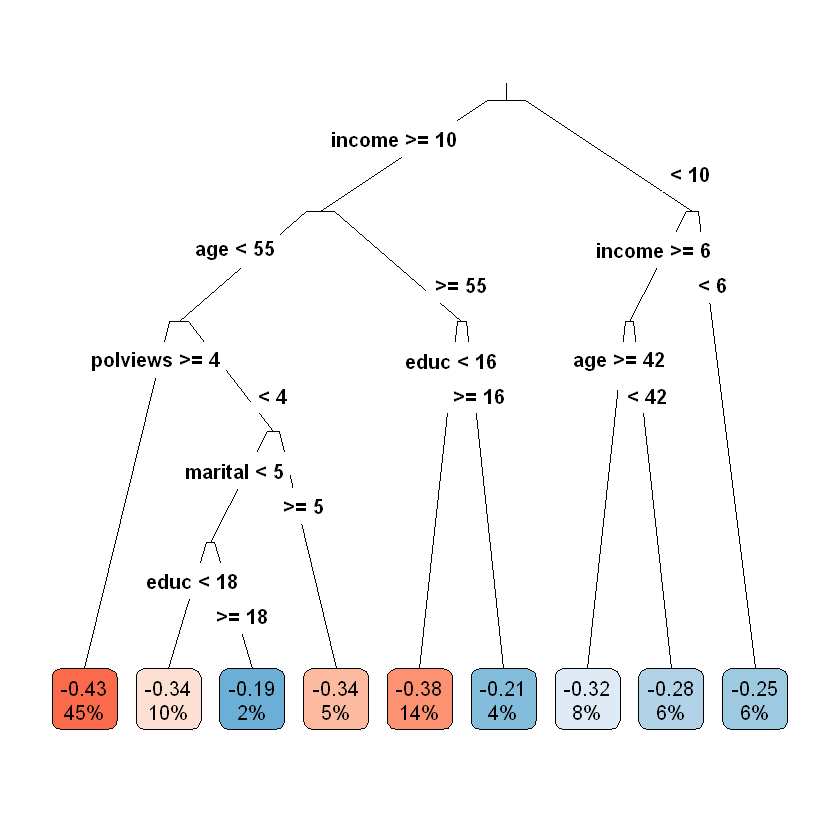

In [11]:
rpart.plot(
  x=ct.pruned,        # Pruned tree
  type=3,             # Draw separate split labels for the left and right directions
  fallen=TRUE,        # Position the leaf nodes at the bottom of the graph
  leaf.round=1,       # Rounding of the corners of the leaf node boxes
  extra=100,          # Display the percentage of observations in the node
  branch=.1,          # Shape of the branch lines
  box.palette="RdBu") # Palette for coloring the node

<font size=1>
Interpret the heatmap above. What describes the subgroups with strongest and weakest estimated treatment effect?
</font>


### Via grf

The function `causal_forest` from the package `grf` allows us to get estimates of the CATE \@ref(eq:cate). 

In [ ]:
# Get predictions from forest fitted above.
tau.hat <- predict(forest.tau)$predictions  # tau(X) estimates

Having fit a non-parametric method such as a causal forest, a researcher may (incorrectly) start by looking at the distribution of its predictions of the treatment effect. One might be tempted to think: "if the histogram is concentrated at a point, then there is no heterogeneity; if the histogram is spread out, then our estimator has found interesting heterogeneity." However, this may be false.

In [ ]:
# Do not use this for assessing heterogeneity. See text above.
hist(tau.hat, main="CATE estimates", freq=F)

If the histogram is concentrated at a point, we may simply be underpowered: our method was not able to detect any heterogeneity, but maybe it would detect it if we had more data. If the histogram is spread out, we may be overfitting: our model is producing very noisy estimates $\widehat{\tau}(x)$, but in fact the true  $\tau(x)$ can be much smoother as a function of $x$.

The `grf` package also produces a measure of variable importance that indicates how often a variable was used in a tree split. Again, much like the histogram above, this can be a rough diagnostic, but it should not be interpreted as indicating that, for example, variable with low importance is not related to heterogeneity. The reasoning is the same as the one presented in the causal trees section: if two covariates are highly correlated, the trees might split on one covariate but not the other, even though both (or maybe neither) are relevant in the true data-generating process.

In [ ]:
var_imp <- c(variable_importance(forest.tau))
names(var_imp) <- covariates
sorted_var_imp <- sort(var_imp, decreasing = TRUE)
sorted_var_imp[1:5]  # showing only first few

#### Data-driven subgroups

Just as with causal trees, we can use causal forests to divide our observations into subgroups. In place of leaves, we'll rank observation into (say) quintiles according to their estimated CATE prediction; see, e.g., [Chernozhukov, Demirer, Duflo, Fernández-Val (2020)](https://arxiv.org/abs/1712.04802) for similar ideas.

There's a subtle but important point that needs to be addressed here. As we have mentioned before, when predicting the conditional average treatment effect $\tau(X_i)$ for observation $i$ we should in general avoid using a model that was fitted using observation $i$. This sort of sample splitting (which we called **honesty** above) is one of the required ingredients to get unbiased estimates of the CATE using the methods described here. However, when ranking estimates of two observations $i$ and $j$, we need something a little stronger: we must ensure that the model was not fit using _either_ $i$ _or_ $j$'s data. 

One way of overcoming this obstacle is simple. First, divide the data into $K$ folds (subsets). Then, cycle through the folds, fitting a CATE model on $K-1$ folds. Next, for each held-out fold, _separately_ rank the unseen observations into $Q$ groups based on their prediction  (i.e., if $Q=5$, then we rank observations by estimated CATE into "top quintile", "second quintile", and so on). After concatenating the independent rankings together, we can study the differences in observations in each rank-group. 

[This gist](https://gist.github.com/halflearned/bea4e5137c0c81fd18a75f682da466c8) computes the above for `grf`, and it should not be hard to modify it so as to replace forests by any other non-parametric method. However, for `grf` specifically, there's a small trick that allows us to obtain a valid ranking: we can pass a vector of fold indices to the argument `clusters` and rank observations within each fold. This works because estimates for each fold ("cluster")   trees are computed using trees that were not fit using observations from that fold. Here's how to do it. 


In [ ]:
# Valid randomized data and observational data with unconfoundedness+overlap.
# Note: read the comments below carefully. 
# In randomized settings, do not estimate forest.e and e.hat; use known assignment probs.

# Prepare dataset
fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse="+")))
X <- model.matrix(fmla, data)
W <- data[,treatment]
Y <- data[,outcome]

# Number of rankings that the predictions will be ranking on 
# (e.g., 2 for above/below median estimated CATE, 5 for estimated CATE quintiles, etc.)
num.rankings <- 5  

# Prepare for data.splitting
# Assign a fold number to each observation.
# The argument 'clusters' in the next step will mimick K-fold cross-fitting.
num.folds <- 10
folds <- sort(seq(n) %% num.folds) + 1

# Comment or uncomment depending on your setting.
# Observational setting with unconfoundedness+overlap (unknown assignment probs):
# forest <- causal_forest(X, Y, W, clusters = folds)
# Randomized settings with fixed and known probabilities (here: 0.5).
forest <- causal_forest(X, Y, W, W.hat=.5, clusters = folds)

# Retrieve out-of-bag predictions.
# Predictions for observation in fold k will be computed using 
# trees that were not trained using observations for that fold.
tau.hat <- predict(forest)$predictions

# Rank observations *within each fold* into quintiles according to their CATE predictions.
ranking <- rep(NA, n)
for (fold in seq(num.folds)) {
  tau.hat.quantiles <- quantile(tau.hat[folds == fold], probs = seq(0, 1, by=1/num.rankings))
  ranking[folds == fold] <- cut(tau.hat[folds == fold], tau.hat.quantiles, include.lowest=TRUE,labels=seq(num.rankings))
}

The next snippet computes the average treatment effect within each group defined above, i.e., $\E[Y_i(1) - Y_i(0)|G_i = g]$. This can done in two ways. First, by computing a simple difference-in-means estimate of the ATE based on observations within each group. This is valid only in randomized settings.

In [ ]:
# Valid only in randomized settings.
# Average difference-in-means within each ranking

# Formula y ~ 0 + ranking + ranking:w
fmla <- paste0(outcome, " ~ 0 + ranking + ranking:", treatment)
ols.ate <- lm(fmla, data=transform(data, ranking=factor(ranking)))
ols.ate <- coeftest(ols.ate, vcov=vcovHC(ols.ate, type='HC2'))
interact <- which(grepl(":", rownames(ols.ate)))
ols.ate <- data.frame("ols", paste0("Q", seq(num.rankings)), ols.ate[interact, 1:2])
rownames(ols.ate) <- NULL # just for display
colnames(ols.ate) <- c("method", "ranking", "estimate", "std.err")
ols.ate

Another option is to average the AIPW scores within each group. This valid for both randomized settings and observational settings with unconfoundedness and overlap. Moreover, AIPW-based estimators should produce estimates with tighter confidence intervals in large samples.

In [ ]:
# Computing AIPW scores.
tau.hat <- predict(forest)$predictions
e.hat <- forest$W.hat # P[W=1|X]
m.hat <- forest$Y.hat # E[Y|X]

# Estimating mu.hat(X, 1) and mu.hat(X, 0) for obs in held-out sample
# Note: to understand this, read equations 6-8 in this vignette:
# https://grf-labs.github.io/grf/articles/muhats.html
mu.hat.0 <- m.hat - e.hat * tau.hat        # E[Y|X,W=0] = E[Y|X] - e(X)*tau(X)
mu.hat.1 <- m.hat + (1 - e.hat) * tau.hat  # E[Y|X,W=1] = E[Y|X] + (1 - e(X))*tau(X)

# AIPW scores
aipw.scores <- tau.hat + W / e.hat * (Y -  mu.hat.1) - (1 - W) / (1 - e.hat) * (Y -  mu.hat.0)
ols <- lm(aipw.scores ~ 0 + factor(ranking))
forest.ate <- data.frame("aipw", paste0("Q", seq(num.rankings)), coeftest(ols, vcov=vcovHC(ols, "HC2"))[,1:2])
colnames(forest.ate) <- c("method", "ranking", "estimate", "std.err")
rownames(forest.ate) <- NULL # just for display
forest.ate

The code below plots the estimates.

In [ ]:
# Concatenate the two results.
res <- rbind(forest.ate, ols.ate)

# Plotting the point estimate of average treatment effect 
# and 95% confidence intervals around it.
ggplot(res) +
  aes(x = ranking, y = estimate, group=method, color=method) + 
  geom_point(position=position_dodge(0.2)) +
  geom_errorbar(aes(ymin=estimate-2*std.err, ymax=estimate+2*std.err), width=.2, position=position_dodge(0.2)) +
  ylab("") + xlab("") +
  ggtitle("Average CATE within each ranking (as defined by predicted CATE)") +
  theme_minimal() +
  theme(legend.position="bottom", legend.title = element_blank())

When there isn't much detectable heterogeneity, the plot above can end up being non-monotonic. This can mean that the number of observations is too small for us to be able to detect subgroups with relevant differences in treatment effect.

<font size=1>
As an exercise, try running the previous two snippets on few data points (e.g., the first thousand observations only). You will likely see the "non-monotonicity" phenomenon just described.
</font>

Next, as we did for leaves in a causal tree, we can test e.g., if the prediction for groups 2, 3, etc. are larger than the one in the first group. Here's how to do it based on a difference-in-means estimator. Note the Romano-Wolf multiple-hypothesis testing correction.

In [ ]:
# Valid in randomized settings only.

# y ~ ranking + w + ranking:w
fmla <- paste0(outcome, "~ ranking + ", treatment, " + ranking:", treatment) 
ols <- lm(fmla, data=transform(data, ranking=factor(ranking)))
interact <- which(sapply(names(coef(ols)), function(x) grepl(":", x)))
res <- summary_rw_lm(ols, indices=interact)
rownames(res) <- paste("Rank", 2:num.rankings, "- Rank 1") # just for display
res

Here's how to do it for AIPW-based estimates, again with Romano-Wolf correction for multiple hypothesis testing. 

In [ ]:
# Valid in randomized and observational settings with unconfoundedness+overlap.

# Using AIPW scores computed above
ols <- lm(aipw.scores ~ 1 + factor(ranking))
res <- summary_rw_lm(ols, indices=2:num.rankings)
rownames(res) <- paste("Rank", 2:num.rankings, "- Rank 1") # just for display
res

Finally, we can also check if different groups have different average covariate levels across rankings. 

In [ ]:
df <- mapply(function(covariate) {
      # Looping over covariate names
      # Compute average covariate value per ranking (with correct standard errors)
      fmla <- formula(paste0(covariate, "~ 0 + ranking"))
      ols <- lm(fmla, data=transform(data, ranking=factor(ranking)))
      ols.res <- coeftest(ols, vcov=vcovHC(ols, "HC2"))
    
      # Retrieve results
      avg <- ols.res[,1]
      stderr <- ols.res[,2]
      
      # Tally up results
      data.frame(covariate, avg, stderr, ranking=paste0("Q", seq(num.rankings)), 
                 # Used for coloring
                 scaling=pnorm((avg - mean(avg))/sd(avg)), 
                 # We will order based on how much variation is 'explain' by the averages
                 # relative to the total variation of the covariate in the data
                 variation=sd(avg) / sd(data[,covariate]),
                 # String to print in each cell in heatmap below
                 labels=paste0(signif(avg, 3), "\n", "(", signif(stderr, 3), ")"))
}, covariates, SIMPLIFY = FALSE)
df <- do.call(rbind, df)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df$covariate <- reorder(df$covariate, order(df$variation))

# plot heatmap
ggplot(df) +
    aes(ranking, covariate) +
    geom_tile(aes(fill = scaling)) + 
    geom_text(aes(label = labels)) +
    scale_fill_gradient(low = "#E1BE6A", high = "#40B0A6") +
    ggtitle(paste0("Average covariate values within group (based on CATE estimate ranking)")) +
    theme_minimal() + 
    ylab("") + xlab("CATE estimate ranking") +
    theme(plot.title = element_text(size = 11, face = "bold"),
          axis.text=element_text(size=11)) 

<font size=1>
Interpret the heatmap above. What describes the subgroups with strongest and weakest estimated treatment effect? Are there variables that seem to increase or decrease monotonically across rankings?
</font>

#### Best linear projection

This function provides a doubly robust fit to the linear model $\widehat{\tau}(X_i) = \beta_0 + A_i'\beta_1$, where $A_i$ can be a subset of the covariate columns. The coefficients in this regression are suggestive of general trends, but they should not be interpret as partial effects -- that would only be true if the true model were really linear in covariates, and that's an assumption we shouldn't be willing to make in general.

In [ ]:
# Best linear projection of the conditional average treatment effect on covariates
best_linear_projection(forest.tau, X)

#### Assessing heterogeneity

The function `test_calibration` computes an estimate of the best linear predictor of true CATE based on out-of-bag predictions $\hat{\tau}^{-i}(\cdot)$. The exact implementation seeks to fit the following linear model:
\begin{equation}
Y_{i} - \hat{m}^{-i}(X_{i}) = \alpha\bar{\tau}\left(W_{i} - \hat{e}^{-i}(X_{i})\right) + \beta \left(\hat{\tau}^{-i}(X_{i}) - \bar{\tau} \right) \left(W_{i} - \hat{e}^{-i}(X_{i}) \right) + \epsilon,
\end{equation}

where $\bar{\tau} := n^{-1}\sum_{i=1}^{n} \hat{\tau}^{-i}(X_{i})$. The coefficients $\alpha$ and $\beta$ allow us to evaluate the performance of our estimates. If $\alpha = 1$, then the average prediction produced by the forest is correct. Meanwhile, if $\beta = 1$, then the forest predictions adequately capture the underlying heterogeneity.

The slope $\beta$ is a measure of how the CATE predictions covary with true CATE. Therefore, the p-value on the estimate of coefficient also acts as an omnibus test for the presence of heterogeneity. If the coefficient is significantly greater than zero, then we can reject the null of no heterogeneity. However, coefficients smaller than 0 are not meaningful and show not be interpreted.

In [ ]:
test_calibration(forest.tau)

<font size=1>
Interpret the test above. Is the forest producing correct estimate of the average treatment effect? Is it capturing the underlying heterogeneity?
</font>

#### Partial dependence

It may also be interesting to examine how our CATE estimates behave when we change a single covariate, while keeping all the other covariates at a some fixed value. In the plot below we evaluate a variable of interest across quantiles, while keeping all other covariates at their median. 

It is important to recognize that by keeping some variables at their median we may be evaluating the CATE at $x$ values in regions where there are few or no data points. Also, it may be the case that varying some particular variable while keeping others fixed may just not be very interesting.

In what follows we'll again use `causal_forest` predictions, along with their variance estimates (set `estimate.variances=TRUE` when predicting to we get estimates of the asymptotic variance of the prediction for each point). Since `grf` predictions are asymptotically normal, we can construct 95\% confidence intervals in the usual manner (i.e., $\hat{\tau}(x) \pm 1.96\sqrt{\widehat{\text{Var}}(\hat{\tau}(x))}$).

In [ ]:
selected.covariate <- "polviews"
other.covariates <- covariates[which(covariates != selected.covariate)]

# Fitting a forest 
# (commented for convenience; no need re-fit if already fitted above)
fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse="+")))
# Note: For smaller confidence intervals, set num.trees ~ sample size
# X <- model.matrix(fmla, data)
# W <- data[,treatment]
# Y <- data[,outcome]
# forest.tau <- causal_forest(X, Y, W, W.hat=.5)  # few trees for speed here

# Compute a grid of values appropriate for the selected covariate
grid.size <- 7 
covariate.grid <- seq(min(data[,selected.covariate]), max(data[,selected.covariate]), length.out=grid.size)

# Other options for constructing a grid:
# For a binary variable, simply use 0 and 1
# grid.size <- 2
# covariate.grid <- c(0, 1)  

# For a continuous variable, select appropriate percentiles
# percentiles <- c(.1, .25, .5, .75, .9)
# grid.size <- length(percentiles)
# covariate.grid <- quantile(data[,selected.covariate], probs=percentiles)

# Take median of other covariates 
medians <- apply(data[, other.covariates, F], 2, median)

# Construct a dataset
data.grid <- data.frame(sapply(medians, function(x) rep(x, grid.size)), covariate.grid)
colnames(data.grid) <- c(other.covariates, selected.covariate)

# Expand the data
X.grid <- model.matrix(fmla, data.grid)

# Point predictions of the CATE and standard errors 
forest.pred <- predict(forest.tau, newdata = X.grid, estimate.variance=TRUE)
tau.hat <- forest.pred$predictions
tau.hat.se <- sqrt(forest.pred$variance.estimates)

# Plot predictions for each group and 95% confidence intervals around them.
data.pred <- transform(data.grid, tau.hat=tau.hat, ci.low = tau.hat - 2*tau.hat.se, ci.high = tau.hat + 2*tau.hat.se)
ggplot(data.pred) +
  geom_line(aes_string(x=selected.covariate, y="tau.hat", group = 1), color="black") +
  geom_errorbar(aes_string(x=selected.covariate, ymin="ci.low", ymax="ci.high", width=.2), color="blue") +
   ylab("") +
  ggtitle(paste0("Predicted treatment effect varying '", selected.covariate, "' (other variables fixed at median)")) +
  scale_x_continuous("polviews", breaks=covariate.grid, labels=signif(covariate.grid, 2)) +
  theme_minimal() +
  theme(plot.title = element_text(size = 11, face = "bold")) 

Note that, in this example, we got fairly large confidence intervals. This can be explained in two ways. First, as we mentioned above, there's a data scarcity problem. For example, even though the number of observations with `polviews` equal to `6` is not small,

In [ ]:
with(data, mean(polviews == 6))

there's a much smaller fraction of individuals with `polviews` equal to `6` and (say) age close to the median age,

In [ ]:
mean(with(data, (polviews == 6) & (abs(age - median(age)) <= 3))) # at most 3 yrs away

and an even smaller fraction of observations with `polviews` equal to `6` and every other variable close to the median. The second cause of wide confidence intervals is statistical. Since `grf` is a non-parametric model, we should expect fairly wide confidence intervals, especially in high-dimensional problems -- that is an unavoidable consequence of avoiding modeling assumptions. 

<font size=2>
As documented in the original paper on generalized random forests ([Athey, Tibshirani and Wager, 2019](https://arxiv.org/abs/1610.01271)), the coverage of `grf` confidence intervals can drop if the signal is too dense or too complex relative to the number of observations. Also, to a point, it's possible to get tighter confidence intervals by increasing the number of trees; see this [short vignette](https://grf-labs.github.io/grf/articles/ci_and_num.trees.html) for more information. 
</font>

We can vary more than one variable at a time. The next snippet shows predictions and standard errors varying two variables.

In [ ]:
x1 <- 'polviews'
x2 <- 'age'
selected.covariates <- c(x1, x2)
other.covariates <- covariates[-which(covariates %in% selected.covariates)]

# Compute a grid of values appropriate for the selected covariate
# See other options for constructing grids in the snippet above.
x1.grid.size <- 7
x2.grid.size <- 5
x1.grid <- seq(min(data[,x1]), max(data[,x1]), length.out=x1.grid.size)
x2.grid <- seq(min(data[,x2]), max(data[,x2]), length.out=x2.grid.size)

# Take median of other covariates 
medians <- apply(data[, other.covariates, F], 2, median)

# Construct dataset
data.grid <- data.frame(
                sapply(medians, function(x) rep(x, grid.size)), 
                expand.grid(x1.grid, x2.grid))
colnames(data.grid) <- c(other.covariates, selected.covariates)

# Expand the data according to formula used to fit forest
X.grid <- model.matrix(fmla, data.grid)

# Forest-based point estimates of CATE and standard errors around them
forest.pred <- predict(forest.tau, newdata = X.grid, estimate.variance=TRUE)
tau.hat <- forest.pred$predictions
tau.hat.se <- sqrt(forest.pred$variance.estimates)

# A vector of labels for plotting below
labels <- mapply(function(est, se) paste0(signif(est, 3), "\n", "(", signif(se, 3), ")"), tau.hat, tau.hat.se)
df <- data.frame(X.grid, tau.hat, labels)

# Plotting
ggplot(df) +
    aes(age, polviews) +
    geom_tile(aes(fill = tau.hat)) + 
    geom_text(aes(label = labels)) +
    scale_fill_gradient(low = "blue", high = "orange") +
    scale_y_continuous("polviews", breaks=x1.grid, labels=signif(x1.grid, 2)) +
    scale_x_continuous("age", breaks=x2.grid, labels=signif(x2.grid, 2)) +
    ggtitle(paste0("Predicted treatment effect varying '", x1, "' and '", x2, "' (other variables fixed at median)")) +
    theme_minimal() +
    theme(plot.title = element_text(size = 10, face = "bold")) 

## Further reading

A readable summary of different method for hypothesis testing correction is laid out in the introduction to [Clarke, Romano and Wolf (2009)](http://ftp.iza.org/dp12845.pdf).

[Athey and Wager (2019)](https://arxiv.org/abs/1902.07409) shows an application of causal forests to heterogeity analysis in a setting with clustering.